In [1]:
from functions import vectorize_y_ser

In [2]:
import datetime

In [3]:
import nltk
import string

In [4]:
import re

In [5]:
import pickle

In [6]:
import pandas as pd
import numpy as np

In [7]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [9]:
from collections import Counter

In [10]:
from imblearn.under_sampling import RandomUnderSampler

In [11]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# NLP Pipeline 

![](images/pipeline-walkthrough1.png)

Below is a to do list when converting text into vector form: 

**Clean text and Create a Bag of Words (BoW)**
>1. Lowercase the text
2. Tokenize 
3. Strip out punctuation or undesirable text
4. Remove Stopwords 
5. Stemming or Lemmatizing
6. Compute N-Grams
7. Use this to create BoW

**Vectorize BoW**
>8. Term Frequencies
9. Document Frequencies
10. TF-IDF
11. Normalize vectors

Let's go through both what each of these steps are and how to do them in python with the following corpus of comments about data science...
 

In [12]:
# function to vectorize the type_of_material series into a y target vector.
def vectorize_y_ser(ser):
    y = ser.copy()
    y.replace({'Op-Ed': 1,'News': 0}, inplace=True)
    return y

In [13]:
#rate of correct predictions out of total predictions
def metrics_(tn, fp, fn, tp):
    accuracy = (tp + tn) / (tn + fn + tp + fp)
    print(f'accuracy = {accuracy}')
    recall = (tp) / (tp + fn)
    print(f'recall = {recall}')
    precision = (tp) / (tp + fp)
    print(f'precision = {precision}')
    print(f'tn:{tn} fp:{fp} fn:{fn} tp:{tp}')

In [14]:
#function that removes string.punctuation w/out the '?'
def punc_strip(document):
    for char in document:
        if char in '!"#$%&\'()*+—,-./:;<=>?@[\\]^_`{|}~”’“':
            document = document.replace(char, " ") 
    return document

In [15]:
import os
import glob
import pandas as pd

#extension = 'csv'
#all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
df2020 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2020.csv'
df2019 = '/Users/djbetts/Desktop/opinion_classifier/data/archive/raw_2019.csv'

#combine print, type, text columns in the list
def printed(file):
    print_cols = ['_id','print_page','pub_date','keywords','type_of_material','text']    
    df = pd.read_csv(file, usecols=print_cols, index_col='_id', low_memory=False)
    df = df[df.print_page.isna() == False]
    df = df[~df.text.isna() == True]
    return df

In [16]:
#returns articles w/ 'United States Politics and Government' as a keyword
def return_pol_gov(row):
    list_dict = eval(row.keywords)
    for (dic) in (list_dict):
        if dic.get('value') == 'United States Politics and Government':
            return True

In [17]:
def filter_keyword(df, keyword='United States Politics and Government'):
    df[keyword] = df.apply(return_pol_gov, axis=1)    
    df = df[df[keyword] == True]
    return df

In [18]:
#returns shape of news and oped
def oped_v_news(df):
    news_df = df[df.type_of_material == "News"]
    oped_df = df[df.type_of_material == "Op-Ed"]
    print(f"news shape:{news_df.shape}, oped shape:{oped_df.shape}, ratio: {oped_df.shape[0]/news_df.shape[0]}")

In [19]:
printed_2020 = printed(df2020)
printed_2019 = printed(df2019)

In [20]:
print(printed_2020.shape)
print(printed_2019.shape)

(27752, 5)
(30232, 5)


# filter keywords

In [21]:
keyword_df2019 = filter_keyword(printed_2019)
keyword_df2020 = filter_keyword(printed_2020)

In [22]:
#concat df together
df = pd.concat([keyword_df2019, keyword_df2020])

In [23]:
%%time
df = df.copy()

CPU times: user 1.22 ms, sys: 245 µs, total: 1.46 ms
Wall time: 1.42 ms


In [24]:
df.shape

(8877, 6)

In [25]:
df.text.iloc[0]

'WASHINGTON — Federal prosecutors rebuffed a judge’s order to release by Friday highly classified transcripts of discussions that Michael T. Flynn, the president’s former national security adviser, had with the Russian ambassador during the presidential transition.The transcripts between Mr. Flynn and Sergey I. Kislyak, formerly Russia’s top diplomat in the United States, were expected to show that they talked in December 2016 about sanctions that the Obama administration had just imposed on Russia. Mr. Flynn initially denied those exchanges about sanctions both to Trump administration officials and the F.B.I. in the weeks after the discussions.The conversations prompted concerns among senior Obama administration officials about whether the Trump transition team was flouting norms about holding off on making policy until after taking office. The phone calls were also at the center of the scandal that eventually prompted Mr. Flynn’s ouster just weeks into President Trump’s term.The orde

In [70]:
last_check_before_split = (df.iloc[0])
last_check_before_split

print_page                                                                            22.0
keywords                                 [{'name': 'persons', 'value': 'Flynn, Michael ...
pub_date                                                          2019-06-01T00:32:33+0000
type_of_material                                                                      News
text                                     WASHINGTON — Federal prosecutors rebuffed a ju...
United States Politics and Government                                                 True
Name: nyt://article/0ae91997-445f-5dd6-89a6-ea3cf6a550a6, dtype: object

In [28]:
df.shape

(8877, 6)

# X, y

In [29]:
#define X. X is currently pandas series of unsplit strings
X = df.text

In [30]:
#turn series into list...
corpus = list(X)

In [31]:
# define y as a series of op-ed or news
y = df.type_of_material

In [32]:
vectorize_y_ser(y)

_id
nyt://article/0ae91997-445f-5dd6-89a6-ea3cf6a550a6    0
nyt://article/033c09be-8081-5ab2-bc5c-8120ee1da253    1
nyt://article/85ca7462-2ada-5c4c-9c4f-e08c833d89d3    0
nyt://article/cebe94a7-f72a-5534-883d-a6a6669ff987    0
nyt://article/26f83d11-c666-5dd7-bb01-c79245874a41    0
                                                     ..
nyt://article/2bfafff5-96ce-5dba-acf8-e2d5f8eab27e    1
nyt://article/7254685b-f45b-5165-a4a0-8aeab43d9841    0
nyt://article/78e5cf9b-da8f-5fe1-8b69-4f91d4c5e174    0
nyt://article/12aacb9c-8972-5cce-add8-c8c0cebe74e0    0
nyt://article/34f9a992-f1c9-53f7-ad81-67d9f064908e    0
Name: type_of_material, Length: 8877, dtype: int64

In [33]:
%%time
# vectorize y in to (1, 0) (op-ed, news)
y = vectorize_y_ser(y)

CPU times: user 3.87 ms, sys: 771 µs, total: 4.64 ms
Wall time: 4.26 ms


In [34]:
y.value_counts()

0    7357
1    1520
Name: type_of_material, dtype: int64

In [35]:
y.shape

(8877,)

# remove stop words

# stemming/lemmatization

In [36]:
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

In [37]:
%%time
def snowball_tokenize(doc):
    snowball = SnowballStemmer('english')
    return [snowball.stem(word) for word in word_tokenize(doc.lower())]

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.05 µs


In [38]:
%%time
def wordnet_tokenize(doc):
    wordnet = WordNetLemmatizer()
    return  [wordnet.lemmatize(word) for word in word_tokenize(doc.lower())]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


# vectorizer

# SNOWBALL tfidf

In [39]:
# %%time
# #create vectorizer

# snow_vectorizer = TfidfVectorizer(#input='content', 
# #                 encoding='utf-8', 
# #                 decode_error='strict', 
#                  strip_accents='ascii', 
#                  lowercase=True, 
# #                 preprocessor=None, 
#                  tokenizer=snowball_tokenize, 
# #                 analyzer='word', 
#                  stop_words='english', 
# #                 token_pattern='(?u)\b\w\w+\b', 
# #                 ngram_range=(1, 1), 
#                  max_df=0.90, 
#                  min_df=0.10, 
#                  max_features=None, 
# #                 vocabulary=None, 
# #                 binary=False, 
# #                 dtype=<class 'numpy.float64'>, 
# #                 norm='l2', 
# #                 use_idf=True, 
# #                 smooth_idf=True, 
# #                 sublinear_tf=False
# )

<!-- /Users/djbetts/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent)) -->

# WORDNET tfidf

In [40]:
#function that removes string.punctuation w/out the '?'
def punc_strip(document):
    for char in document:
        if char in '!"#$%&\'()*+—,-./:;<=>?@[\\]^_`{|}~”’':
            document = document.replace(char, " ")
            
    return document

In [41]:
stop_words = ['said','a','b','c','d', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'mr','ms']


In [42]:
%%time
#create vectorizer

wordnet_vectorizer = TfidfVectorizer(#input='content', 
#                 encoding='utf-8', 
#                 decode_error='strict', 
#                 strip_accents='ascii', 
                 lowercase=True, 
                 preprocessor=punc_strip, 
                 tokenizer=wordnet_tokenize, 
#                 analyzer='word', 
#                 stop_words=stop_words, 
#                 token_pattern='(?u)\b\w\w+\b', 
                 ngram_range=(1, 1), 
                 max_df=0.9, 
                 min_df=0.1, 
                 max_features=None, 
#                 vocabulary=None, 
#                 binary=False, 
#                 dtype=<class 'numpy.float64'>, 
#                 norm='l2', 
#                 use_idf=True, 
#                 smooth_idf=True, 
#                 sublinear_tf=False
)

CPU times: user 40 µs, sys: 1e+03 ns, total: 41 µs
Wall time: 44.1 µs


# test, train, split

In [43]:
#test, train, split 

In [44]:
%%time
#test, train, split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6657,) (2220,) (6657,) (2220,)
CPU times: user 6.76 ms, sys: 1.54 ms, total: 8.3 ms
Wall time: 7.23 ms


In [45]:
%%time
print(datetime.datetime.now())
X_train =  wordnet_vectorizer.fit_transform(X_train)

2021-01-07 12:16:17.618631
CPU times: user 1min 4s, sys: 700 ms, total: 1min 5s
Wall time: 1min 5s


In [46]:
%%time
print(datetime.datetime.now())
X_test = wordnet_vectorizer.transform(X_test)

2021-01-07 12:17:23.401133
CPU times: user 20.6 s, sys: 211 ms, total: 20.8 s
Wall time: 21 s


In [47]:
vocab = wordnet_vectorizer.vocabulary_

In [48]:
len(vocab)

1053

In [49]:
X_train.shape

(6657, 1053)

In [50]:
X_test.shape

(2220, 1053)

# count vectorizer

In [51]:
# count_vectorizer = CountVectorizer(strip_accents='None',
#                                    lowercase=True,
#                                    tokenizer=snowball_tokenize,
#                                    stop_words='english',
#                                    max_features=None)

# balance classes

In [52]:
%%time
#balance the classes

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)

#X, y --> X_resampled, y_resampled
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))
print(rus)

[(0, 1136), (1, 1136)]
RandomUnderSampler(random_state=0)
CPU times: user 7.92 ms, sys: 1.71 ms, total: 9.63 ms
Wall time: 8.82 ms


# random forest classifier

In [53]:
%%time
print(datetime.datetime.now())
rf_clf = RandomForestClassifier(max_depth=2, random_state=0)


2021-01-07 12:17:44.432521
CPU times: user 306 µs, sys: 85 µs, total: 391 µs
Wall time: 395 µs


In [54]:
rf_clf.fit(X_resampled, y_resampled)
y_pred = rf_clf.predict(X_test)
y_pred.shape

(2220,)

### metrics y_pred

In [55]:
tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred = y_pred).ravel()

In [56]:
print(y_test.shape)
print(y_pred.shape)

(2220,)
(2220,)


In [57]:
metrics_(tn, fp, fn, tp)

accuracy = 0.9162162162162162
recall = 0.9036458333333334
precision = 0.6995967741935484
tn:1687 fp:149 fn:37 tp:347


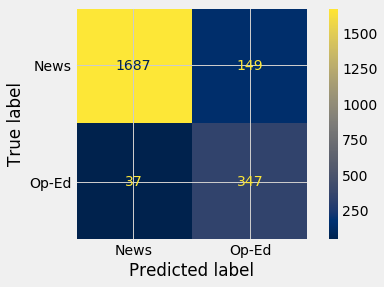

In [58]:
class_names = ["News", "Op-Ed"]
plot_confusion_matrix(estimator=rf_clf,
                      X=X_test,
                      y_true=y_test,
                      display_labels=class_names,
                     cmap='cividis')

plt.savefig('../img/confusion_matrix.png');

# important features

### feature imporance

2021-01-07 12:17:45.281148
CPU times: user 368 ms, sys: 14.8 ms, total: 383 ms
Wall time: 389 ms


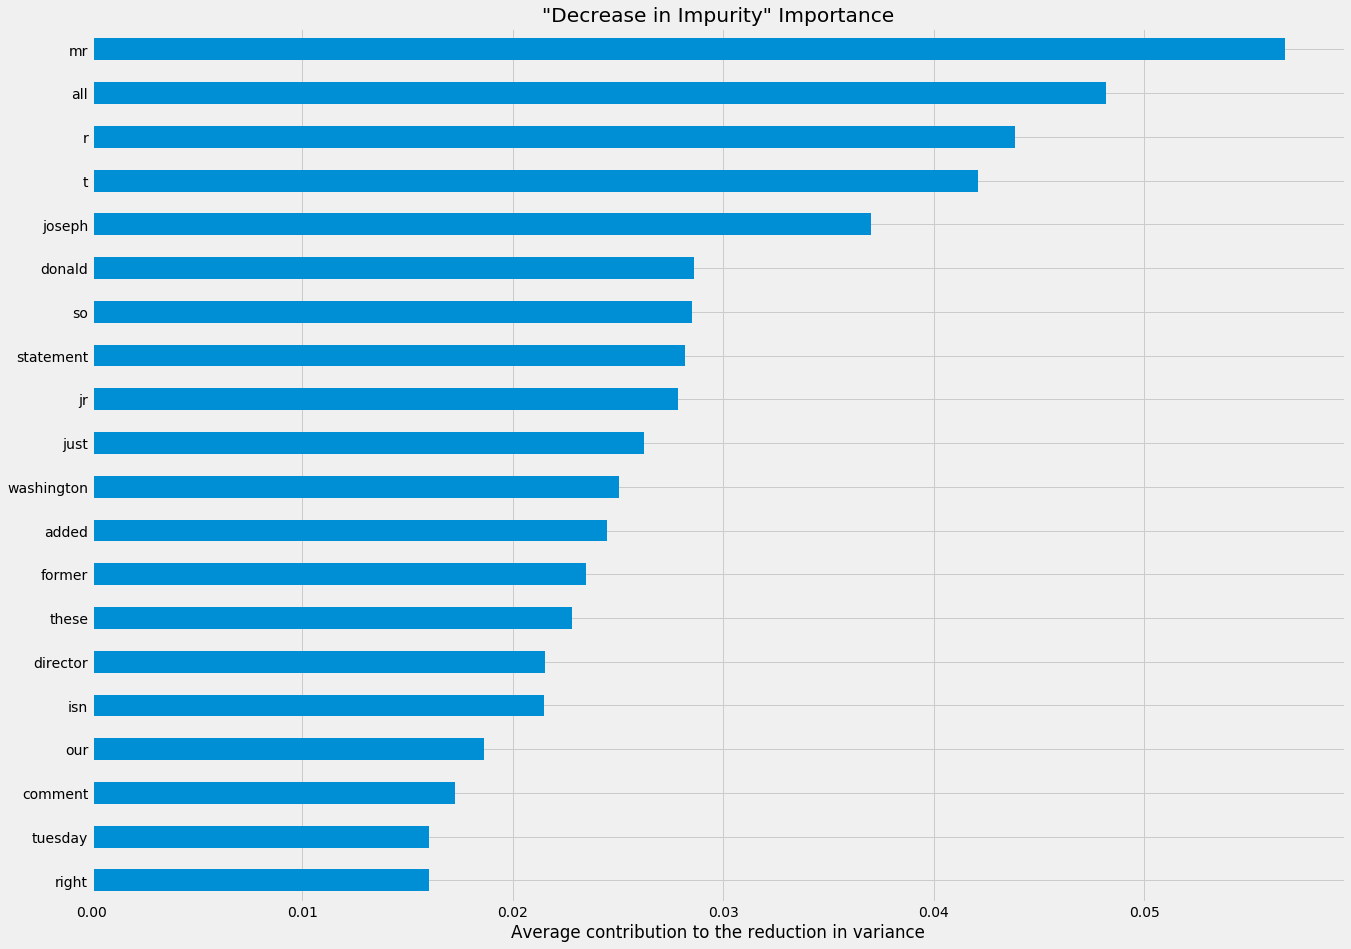

In [59]:
%%time
print(datetime.datetime.now())

feat_names = wordnet_vectorizer.get_feature_names()
feature_import = rf_clf.feature_importances_

feat_scores = pd.Series(feature_import,
                           index=feat_names)
feat_scores = feat_scores.sort_values()
ax = feat_scores[-20:].plot(kind='barh', figsize=(20,15))
ax.set_title('"Decrease in Impurity" Importance')
ax.set_xlabel('Average contribution to the reduction in variance')
plt.savefig('../img/feature_imporance.png');

### permutation importance

In [60]:
# %%time
# print(datetime.datetime.now())
# r = permutation_importance(rf_clf, X_test.toarray(), y_test, n_repeats=30, random_state=0)
# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{feat_names[i]:<8}"
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")

In [61]:
len(feat_names)

1053

In [62]:
feat_names

['000',
 '1',
 '10',
 '100',
 '11',
 '12',
 '15',
 '19',
 '2',
 '20',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '25',
 '3',
 '30',
 '4',
 '40',
 '5',
 '50',
 '6',
 '7',
 '8',
 'ability',
 'able',
 'access',
 'according',
 'account',
 'accused',
 'acknowledged',
 'across',
 'act',
 'acting',
 'action',
 'activist',
 'activity',
 'actually',
 'added',
 'adding',
 'additional',
 'address',
 'administration',
 'advantage',
 'adviser',
 'affair',
 'after',
 'again',
 'against',
 'agency',
 'agenda',
 'ago',
 'agree',
 'agreed',
 'agreement',
 'ahead',
 'aid',
 'aide',
 'air',
 'all',
 'allow',
 'allowed',
 'ally',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'america',
 'american',
 'amid',
 'among',
 'amount',
 'announced',
 'another',
 'answer',
 'anti',
 'any',
 'anyone',
 'anything',
 'appeal',
 'appear',
 'appearance',
 'appeared',
 'appears',
 'approach',
 'approval',
 'april',
 'area',
 'argued',
 'argument',
 'around',
 'article',
 'ask',
 

In [63]:
stop_words = wordnet_vectorizer.stop_words_

In [64]:
len(stop_words)

54555

# save model as pickle file

In [65]:
filename = '/Users/djbetts/Desktop/full_dataset.pkl'

In [66]:
#pickle.dump(rf_clf, open(filename, 'wb'))

In [67]:
#loaded_model = pickle.load(open(filename, 'rb'))

In [68]:
#loaded_model.fit(X_resampled, y_resampled)

In [69]:
#result = loaded_model.score(X_resampled, y_resampled)